In [1]:
## Importing the required python libraries 
import os, sys
import warnings
import timeit
import numpy as np
import pandas as pd 
import pkg_resources
import matplotlib.pyplot as plt
import re
import seaborn as sns
from collections import defaultdict


In [2]:
## Importing pergene files 

pergene_files=[]
#data_dir= "../satay/data_files/data_unmerged/"
#data_dir="../transposonmapper/data_files/files4test/"
data_dir="../postprocessed-data/"
#data_dir="../transposonmapper/data_files/"
for root, dirs, files in os.walk(data_dir):
    for file in files:
        if file.endswith("pergene_insertions.xlsx"):
            pergene_files.append(os.path.join(root, file))

list_data=[]
for i in pergene_files:
    list_data.append(pd.read_excel(i,engine='openpyxl',index_col="Unnamed: 0"))

keys=[]
for i in np.arange(0,len(pergene_files)):
    keys.append(pergene_files[i].split("/")[-1].split("_")[0]+"_"+pergene_files[i].split("/")[-1].split("_")[1])

list_data_pd=pd.concat(list_data,axis=0,keys=keys)

In [3]:
## Importing postproccesed data from pipeline

data_post=[]

for i in keys:
    data_post.append(pd.read_excel(data_dir+i+".xlsx",index_col="Unnamed: 0",engine='openpyxl'))
    
list_data_post=pd.concat(data_post,axis=0,keys=keys)
list_data_post.drop(columns=["Feature_alias","Feature_name"],inplace=True)
list_data_post.fillna(1,inplace=True)


In [4]:
## Importing gene protein length , and protein domains coordinates of every gene 

protein_length=pd.read_csv('../data/Gene_Protein_length_yeastmine.tsv',sep="\t")
protein_length.index=protein_length.loc[:,"Gene Name"]
protein_length.drop(columns="Gene Name",inplace=True)

domains_coordinates=pd.read_csv('../data/Domains_all_genes_protein_coordinates_yeastmine.tsv',sep="\t")

domains_coordinates.dropna(inplace=True)
gene_with_introns=pd.read_csv('../data/Gene_Introns.tsv',sep="\t")



In [5]:
## Combine protein length and protein domains coordinates
domains_coordinates.loc[:,"Protein Length"]=np.nan
for gene_name in protein_length.index: 
    tmp=np.where(domains_coordinates.loc[:,"Gene Name"]==gene_name)[0]
    if tmp.size!=0: 
        for i in np.arange(0,len(tmp)):
            domains_coordinates.loc[tmp[i], "Protein Length"]=protein_length.loc[gene_name, "Protein Length"]

domains_coordinates.dropna(inplace=True) # to drop the proteins that do not have protein domains annotated
domains_coordinates.index=domains_coordinates.loc[:,"Gene Name"]
domains_coordinates.drop(columns="Gene Name",inplace=True)

In [6]:
domains_coordinates.head(2)

,Protein Domain,Protein domain description,Protein start location,Protein End location,Method,Domain ID,Protein Length
Gene Name,,,,,,,
AAC1,PF00153,Mitochondrial carrier protein; Mitochondrial s...,10,106,Pfam,2106639,309.0
AAC1,PF00153,Mitochondrial carrier protein; Mitochondrial s...,116,210,Pfam,2106640,309.0


In [7]:

## make a dictionary with protein domains locations per gene , the solution of an array and attaching it
# a dataframe do not work, so I will use a dictionary

list_data_domains_data=list_data_pd.copy()
df=list_data_domains_data.loc["wt_merged"] # as dataset to take info about proteins 
df.set_index("Gene name",inplace=True)

domain_locations=defaultdict(dict)

for j in df.index:
    if j in domains_coordinates.index:
        if len([domains_coordinates.loc[j,"Protein Domain"]])>1:
            for i in np.arange(0,len(domains_coordinates.loc[j,"Protein Domain"].tolist())):
            
                domain_locations[j][i]=(np.array([domains_coordinates.loc[j,"Protein start location"][i],domains_coordinates.loc[j,
        "Protein End location"][i]]))
        else:
            domain_locations[j]=(np.array([domains_coordinates.loc[j,"Protein start location"],domains_coordinates.loc[j,
    "Protein End location"]]))
    else:
        domain_locations[j]=np.nan


domains_names=defaultdict(dict)


for j in df.index:
    if j in domains_coordinates.index:
        if type(domains_coordinates.loc[j,"Protein Domain"])!=str:
            if len(domains_coordinates.loc[j,"Protein Domain"].tolist())>1:
                for i in np.arange(0,len(domains_coordinates.loc[j,"Protein Domain"].tolist())):
                    domains_names[j][i]=np.array(domains_coordinates.loc[j,"Protein Domain"][i])
            else:
                domains_names[j]=np.array(domains_coordinates.loc[j,"Protein Domain"])
        else:
            domains_names[j]=np.array(domains_coordinates.loc[j,"Protein Domain"])
    else:
        domains_names[j]=np.nan
        


# for i in df.index:
#     if i in domains_coordinates.index:
#         df.loc[i,"protein length"]=np.unique(domains_coordinates.loc[i,"Protein Length"]).tolist()

#     else:
#         df.loc[i,"protein length"]=np.nan

protein_length_dict=defaultdict(dict)

for i in df.index:
    if i in domains_coordinates.index:
        protein_length_dict[i]=np.unique(domains_coordinates.loc[i,"Protein Length"]).tolist()
    else:
        protein_length_dict[i]=np.nan


In [8]:
domains_names_df=pd.DataFrame.from_dict(domains_names,orient="index")
domains_names_df.columns=["protein domain"]

domain_locations_df=pd.DataFrame.from_dict(domain_locations,orient="index")
domain_locations_df.columns=["domain locations"]

protein_length_dict_df=pd.DataFrame.from_dict(protein_length_dict,orient="index")

protein_length_dict_df.columns=["protein length"]

In [9]:
# Merge this info with all the keys from the different backgrounds
list_data_pd_merged=[]
for key in keys:
    df=list_data_pd.loc[key]
    df.set_index("Gene name",inplace=True)
    tmp=pd.merge(df,domain_locations_df,left_index=True,right_index=True)
    tmp_I=pd.merge(tmp,domains_names_df,left_index=True,right_index=True)
    tmp_II=pd.merge(tmp_I,protein_length_dict_df,left_index=True,right_index=True)
    list_data_pd_merged.append(tmp_II)



In [10]:
list_data_pd_merged_pd=pd.concat(list_data_pd_merged,keys=keys)

# saving information into an excel sheet to reuse 

#list_data_pd_merged_pd.to_excel("../postprocessed-data/merged-data-with-domains-info.xlsx")


In [11]:
a=list_data_pd_merged_pd.loc["wt_merged"]

a.loc["AAC1"]

Chromosome                                                                   XIII
Start location                                                             387315
End location                                                               388244
Insertion locations             [387357, 387361, 387373, 387402, 387480, 38751...
Reads per insertion location    [6, 41, 48, 6, 104, 262, 19, 95, 155, 84, 9, 7...
Reads                                                                        2388
Insertions                                                                     37
domain locations                                [[10, 116, 217], [106, 210, 304]]
protein domain                               {0: PF00153, 1: PF00153, 2: PF00153}
protein length                                                            [309.0]
Name: AAC1, dtype: object

In [12]:
from get_reads_per_domain import get_reads_per_domain

reads_per_domain_dict=defaultdict(dict)
domain_genomics_dict=defaultdict(dict)

for key in keys:
    A=list_data_pd_merged_pd.loc[key]
    
    for gene in A.index:
  
        a,b=get_reads_per_domain(A,gene)

        reads_per_domain_dict[key,gene]=a
        domain_genomics_dict[key,gene]=b



In [13]:

reads_per_domain_df=pd.DataFrame.from_dict(reads_per_domain_dict,orient="index")
domain_genomics_df=pd.DataFrame.from_dict(domain_genomics_dict,orient="index")




#b=reads_per_domain_df.loc[[("wt_merged","BEM2")],:].dropna(axis=1)

# a=domain_genomics_df.index[0]
# gene="BEM1"
# key="wt_merged"
# gene= "BEM1"

# b=domain_genomics_df.loc[[(key,gene)],:].dropna(axis=1)

# np.array(b).tolist()[0]


# reads_per_domain_df.to_excel("../postprocessed-data/reads-per-domain-all-backgrounds.xlsx")
# domain_genomics_df.to_excel("../postprocessed-data/genetic-coordinates-domains-pfam.xlsx")

#

[[621106.0, 621244.0], [621356.0, 621500.0], [621797.0, 622064.0]]

/data/localhome/linigodelacruz/anaconda3/envs/transposonmapper/lib/python3.9/site-packages/pandas/core/indexing.py:1817: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_single_column(loc, value, pi)


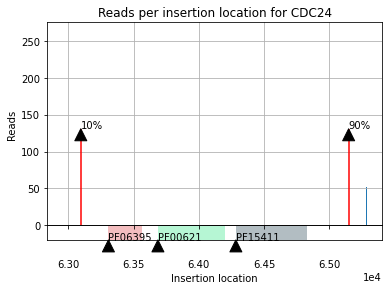

In [22]:
from plot_reads_per_gene_with_domains import plot_reads_per_gene_with_domains
gene="CDC24"
key="wt_merged"
data=list_data_pd_merged_pd.loc[key]
plot_reads_per_gene_with_domains(data=data,gene=gene,domain_genomics_coordinates=domain_genomics_df,key=key)
plt.savefig("../figures/fig_reads_per_gene_with_domains_" + gene + "_"+key+ ".png",dpi=300)

In [15]:

domain_genomic=domain_genomics_df.loc[[(key,gene)],:].dropna(axis=1)

domain_genomic.iloc[0,:].tolist()

[[621106.0, 621244.0], [621356.0, 621500.0], [621797.0, 622064.0]]

In [16]:
from from_excel_to_list import from_excel_to_list

data=list_data_pd_merged_pd.loc[key]
insertions_vector=from_excel_to_list(data.loc[gene,"Insertion locations"])
reads_vector=from_excel_to_list(data.loc[gene,"Reads per insertion location"])
print(insertions_vector,reads_vector)

[620955.0, 620961.0, 621093.0, 621127.0, 621149.0, 621153.0, 621153.0, 621154.0, 621154.0, 621240.0, 621265.0, 621337.0, 621338.0, 621338.0, 621526.0, 621842.0] [5.0, 3.0, 1.0, 1.0, 103.0, 1.0, 1.0, 1.0, 43.0, 91.0, 2.0, 64.0, 5.0, 1.0, 1.0, 3.0]


In [23]:

b=reads_per_domain_df.loc[[(key,gene)],:].dropna(axis=1)

np.array(b).tolist()[0]

[410.0, 0.0, 267.0]

In [27]:
list_data_pd_merged_pd.loc[key,gene]["protein domain"]

array({0: array('PF00621', dtype='<U7'), 1: array('PF06395', dtype='<U7'), 2: array('PF15411', dtype='<U7')},
      dtype=object)